In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

In [16]:
def search_keypoints_heuristic(point_cloud,
                               n_clusters=8):
    p = np.squeeze(point_cloud)
    center = np.mean(p, axis=0)
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0).fit(p)
    centers = kmeans.cluster_centers_
    hull = ConvexHull(centers[:, :2])
    hull = centers[hull.vertices]
    success = False
    while not success:
        dist = 0.0
        while dist == 0:
            grasping_point = random.choice(centers)
            dist_from_hull = np.linalg.norm(
                grasping_point - hull, axis=1)
            dist = np.amin(dist_from_hull)
        vect_center_grasp = grasping_point - center
        vect_center_hull = hull - center
        cosine = vect_center_grasp * vect_center_hull
        mask = np.sum(cosine, axis=1) < 0
        success = True if np.sum(mask) > 0 else False
    func_point = random.choice(hull[mask])
    grasping_point = np.expand_dims(
        grasping_point, 0).astype(np.float32)
    func_point = np.expand_dims(
        func_point, 0).astype(np.float32)
    
    kmeans = KMeans(
        n_clusters=32,
        random_state=0).fit(p)
    centers_dense = kmeans.cluster_centers_
    hull = ConvexHull(centers_dense[:, :2])
    hull = centers_dense[hull.vertices]
    hull_index = np.argsort(
            np.linalg.norm(func_point - hull, axis=1))[0]
    func_point = hull[np.newaxis, hull_index]
    
    if True:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(p[:, 0], p[:, 1], p[:, 2], c='green', s=0.1, alpha=0.3)
        ax.scatter(
            grasping_point[:, 0],
            grasping_point[:, 1],
            grasping_point[:, 2], c='red')
        ax.scatter(
            func_point[:, 0],
            func_point[:, 1],
            func_point[:, 2], c='orange')
        ax.scatter(
            center[0],
            center[1],
            center[2], c='green')
        ax.view_init(elev=90, azim=0)
        plt.show()
    return grasping_point, func_point


def search_keypoints(point_cloud,
                     n_clusters=8,
                     n_collision_points=6):
    p = np.squeeze(point_cloud)
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0).fit(p)
    centers = kmeans.cluster_centers_
    p_center = np.mean(p, axis=0, keepdims=True)
    dist = np.linalg.norm(centers - p_center, axis=1)
    indices = np.argsort(dist)[::-1]
    
    collision_points = centers[indices[:n_collision_points]]
    
    farest_center = np.expand_dims(centers[indices[0]], axis=0)
    dist_farest = np.linalg.norm(centers - farest_center, axis=1)
    grasping_point = centers[
        random.choice(np.argsort(dist_farest)[1:4])]
    grasping_point = np.expand_dims(grasping_point, axis=0)
    
    handle_axis = farest_center - grasping_point
    handle_axis = handle_axis / np.linalg.norm(
        handle_axis, axis=1, keepdims=True)
    func_candidates = centers[np.argsort(dist_farest)[1:]]
    vect = farest_center - func_candidates
    vect = vect / np.linalg.norm(vect, axis=1, keepdims=True)
    func_index = random.choice(np.argsort(
        np.abs(np.sum(handle_axis * vect, axis=1)))[0:3])
    func_point = np.expand_dims(func_candidates[func_index], 0)
    
    keypoints = [grasping_point, func_point, collision_points]
    
    if True:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(p[:, 0], p[:, 1], p[:, 2], c='green', s=0.1, alpha=0.3)
        ax.scatter(
            grasping_point[:, 0],
            grasping_point[:, 1],
            grasping_point[:, 2], c='red')
        ax.scatter(
            func_point[:, 0],
            func_point[:, 1],
            func_point[:, 2], c='orange')
        ax.view_init(elev=90, azim=0)
        plt.show()

    return keypoints


In [17]:
point_cloud = np.load(open('../../episodes/grasp_4dof_random_single/point_cloud/000000.npy', 'rb'))

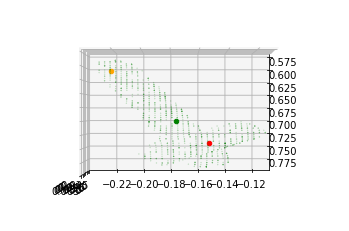

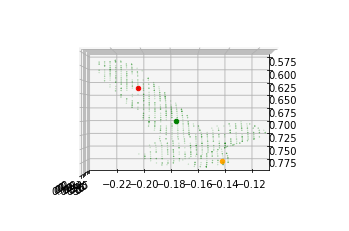

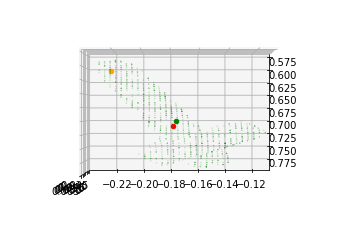

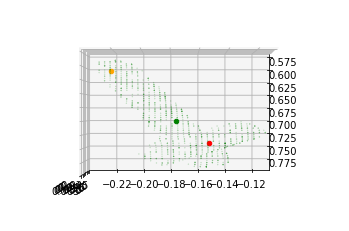

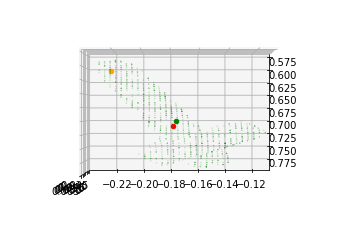

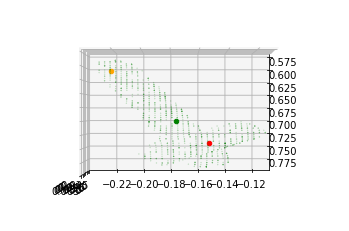

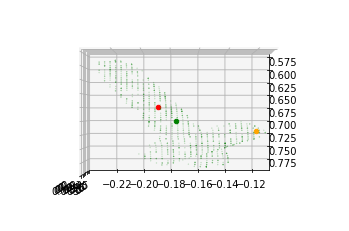

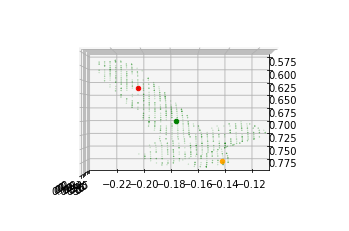

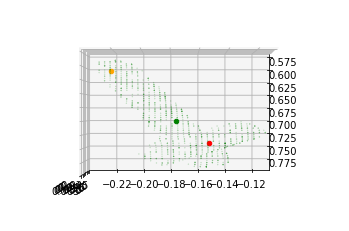

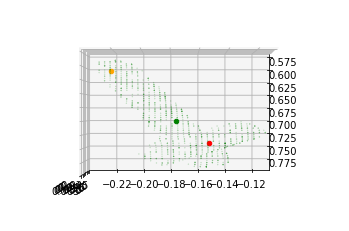

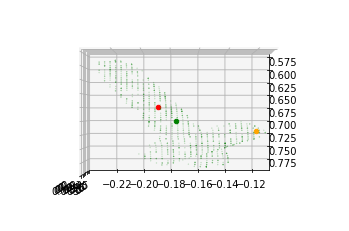

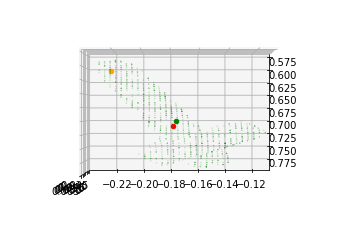

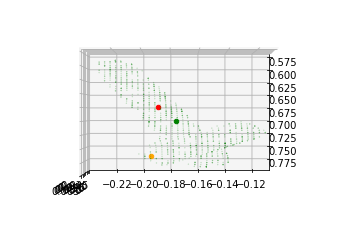

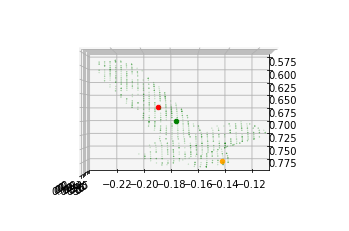

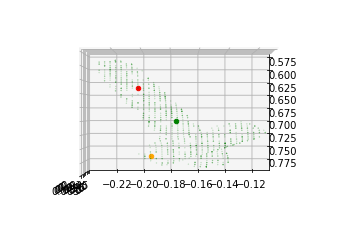

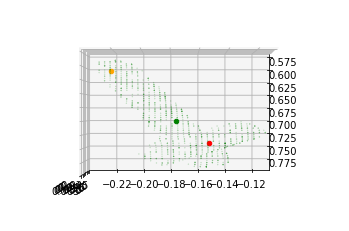

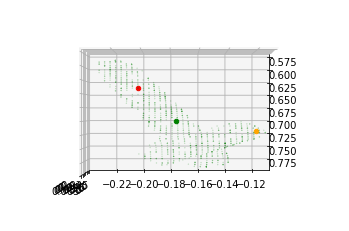

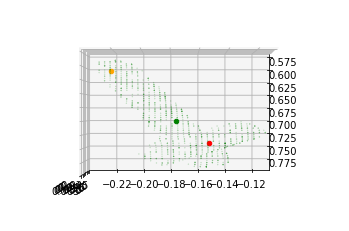

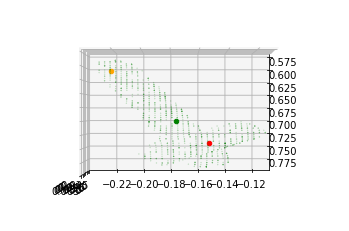

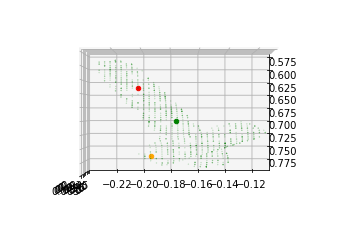

In [18]:
for _ in range(20):
    search_keypoints_heuristic(point_cloud)